# Проект по базовому Python HSE 2023 Fall
Проект - предсказание сложности статьи с сайта n+1

Спарсим все статьи за 2022 год, проанализируем их, сделаем мл-модель и запустим сервис

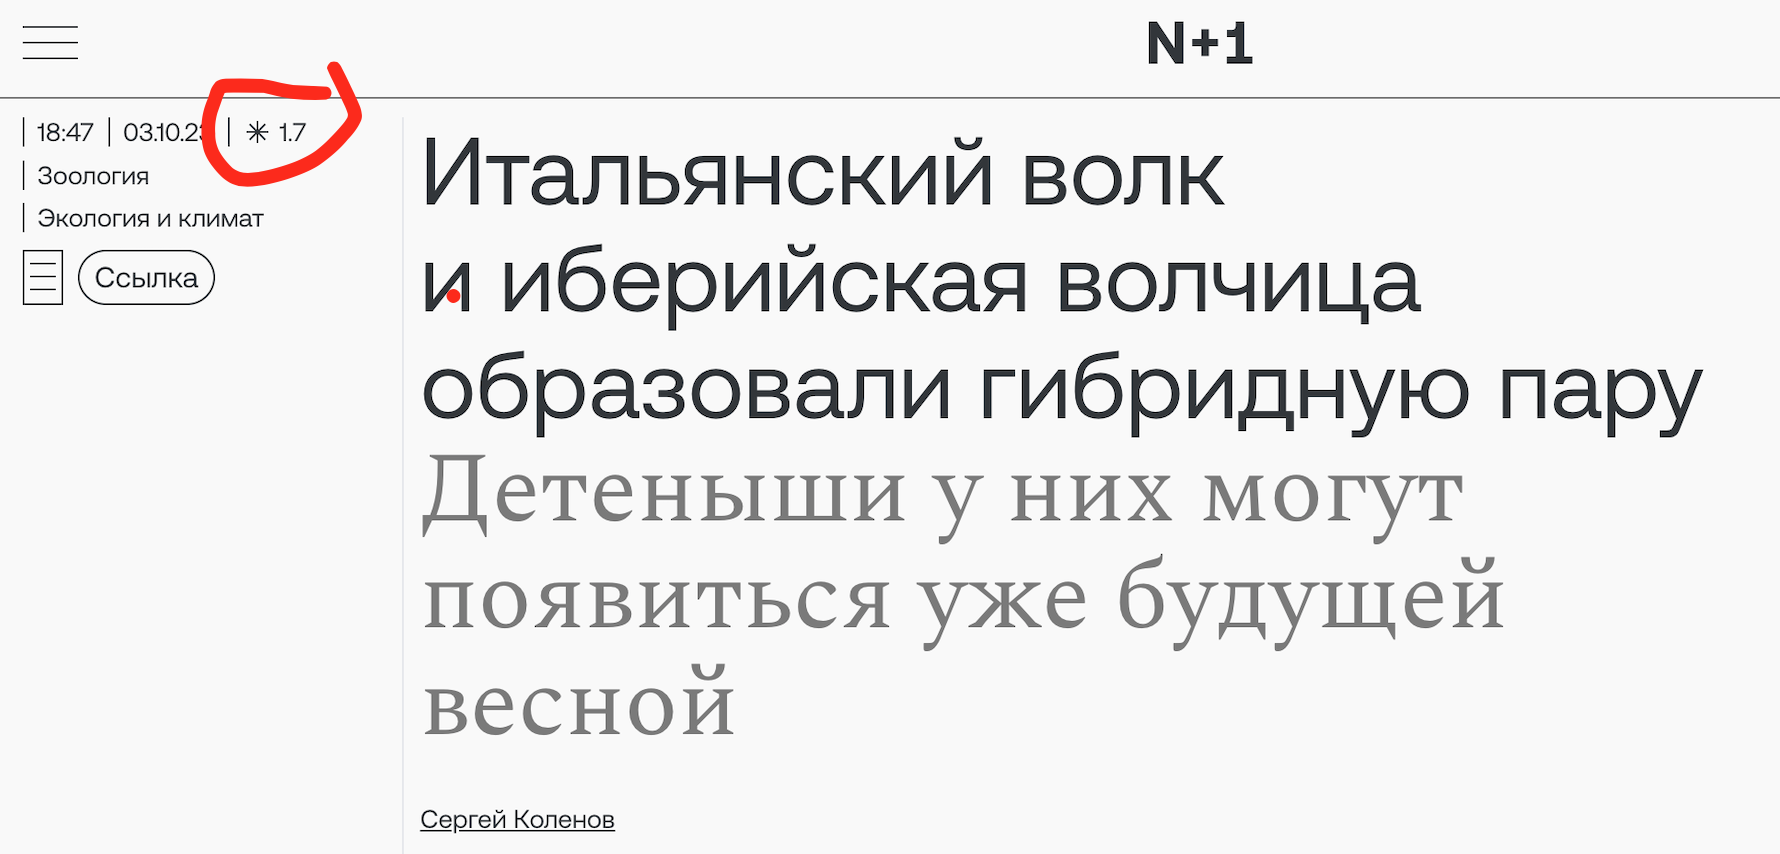

In [1]:
# Устанавливаем и импортируем необходимые пакеты
!pip3 install -q bs4 selenium calplot Catboost pandarallel pymorphy2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.3/448.3 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 102.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00


In [40]:
# импортируем библиотеки
from tqdm import trange
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import joblib
import re
from catboost import CatBoostRegressor
from tqdm.auto import tqdm
import pickle
import calplot
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import warnings
import numpy as np; np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')

from pandarallel import pandarallel
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from math import sin


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Парсинг данных

Будем собирать статьи за 2022 год - заголовок, саму статью и оценки

In [5]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--window-size=1420,1080')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
driver = webdriver.Chrome(options=chrome_options)

In [3]:
dates = [(j.month, j.day) for j in pd.date_range('2022-01-01', '2022-12-31')]

In [4]:
def get_html(link):
    driver.get(link)
    innerHTML = driver.execute_script("return document.body.innerHTML")
    soup = BeautifulSoup(innerHTML, 'html.parser')
    return soup

In [ ]:
d = dict()
for month, day in tqdm(dates, total=len(dates)):
    link = f'https://nplus1.ru/news/2022/{month:02}/{day:02}'
    soup = get_html(link)
    links = [i['href'] for i in soup.find_all('a', class_=lambda x: x and x.startswith('n1_climb_4'))]
    result = []
    if links:
        for link in tqdm(links, total=len(links), leave=False):
            soup = get_html(link)
            temp_res = []
            for p in soup.find_all('section')[0].find_all('p'):
                if p.find_all('span'):
                    continue
                temp_res.append(p.text.replace('\xa0', ' '))
            title = soup.find_all('h1')[0].text.strip()
            full_text = '\n'.join(temp_res)
            tags = [i.text for i in soup.find_all('div', class_=lambda x: x=='flex flex-wrap lg:mb-10 gap-2 text-tags xl:pr-9'
                )[0].find_all('span', class_=lambda x: x=='group-hover:text-main transition-colors duration-75')]
            result.append(
                (
                    title,
                    full_text,
                    tags
                )
            )
        d[(month, day)] = result

In [ ]:
# сохраняем данные
with open('data.json', 'wb') as f:
    pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# загружаем данные
with open('data.json', 'rb') as f:
    data = pickle.load(f,)

In [6]:
diff_rates = []
for key in data.keys():
    for val in data[key]:
        diff_rates.extend(val[2][2:3])

In [7]:
min([float(t) for t in diff_rates])

1.1

In [8]:
max([float(t) for t in diff_rates])

9.6

## Анализ данных

посмотрим распределение целевого признака - сложности

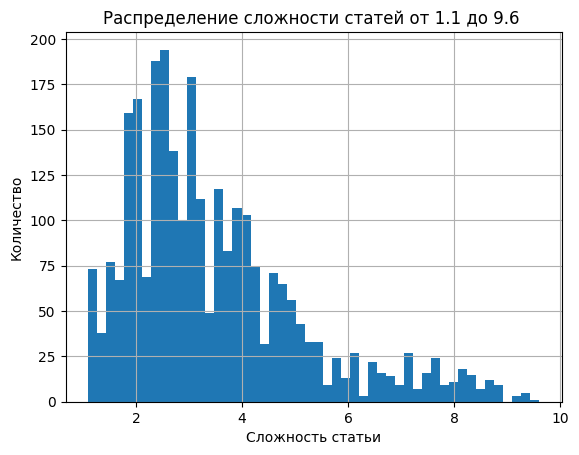

In [9]:
plt.hist([float(t) for t in diff_rates], bins=50)
plt.title('Распределение сложности статей от 1.1 до 9.6 ')
plt.xlabel('Сложность статьи')
plt.ylabel('Количество')
plt.grid()
plt.show()

Видно явное смещение - чтобы избежать смещение модели - во время обучения будем использовать лосс функцию МАЕ

Теперь посмотрим распределение статей по дням

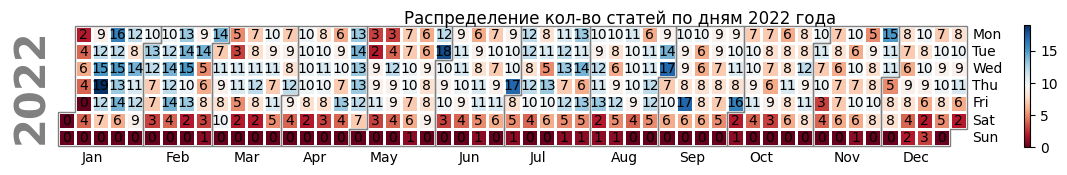

In [10]:
days = pd.date_range('2022-01-01', '2022-12-31')
values = pd.Series([len(data[i]) if data.get(i) else 0 for i in dates], index = days)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
calplot.calplot(values,
                suptitle = 'Распределение кол-во статей по дням 2022 года',
                suptitle_kws = {'x': 0.5, 'y': 1.0},cmap = 'RdBu',
                textformat = '{:.0f}', textfiller = '-', textcolor = 'black')

plt.show()

Видно что в выходные и в праздники выходит меньше всего статей

посмотрим ещё и на распределение средней и медианной целевой переменной по дням

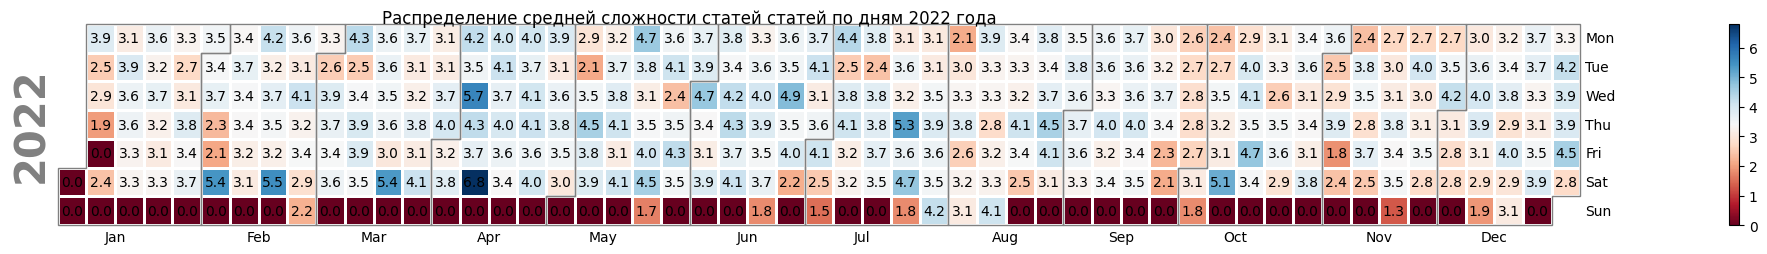

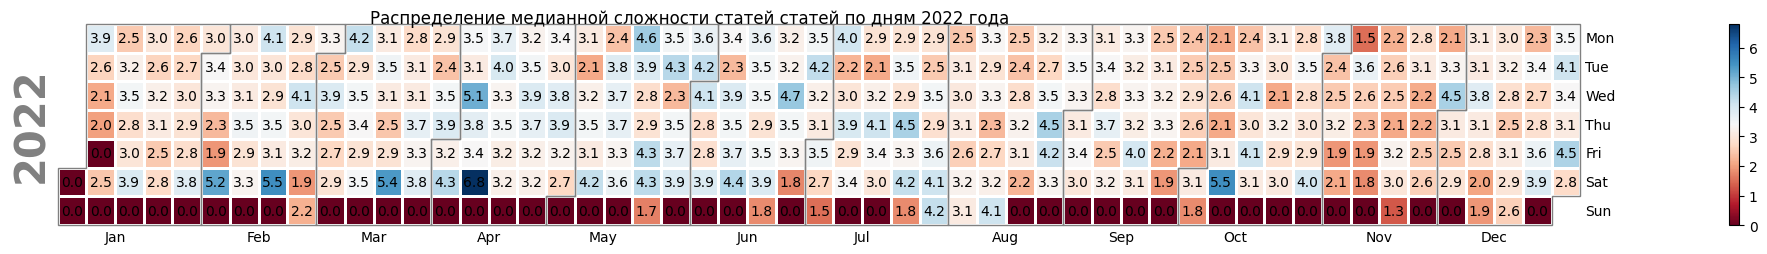

In [12]:
days = pd.date_range('2022-01-01', '2022-12-31')
values = pd.Series([np.mean([float(t[2][2]) for t in data[i]]) if data.get(i) else 0 for i in dates ], index = days)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
calplot.calplot(values, figsize =(30, 2.5),
                suptitle = 'Распределение средней сложности статей статей по дням 2022 года',
                suptitle_kws = {'x': 0.5, 'y': 1.0},cmap = 'RdBu',
                textformat = '{:.1f}', textfiller = '-', textcolor = 'black')

plt.show()

days = pd.date_range('2022-01-01', '2022-12-31')
values = pd.Series([np.median([float(t[2][2]) for t in data[i]]) if data.get(i) else 0 for i in dates ], index = days)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
calplot.calplot(values, figsize =(30, 2.5),
                suptitle = 'Распределение медианной сложности статей статей по дням 2022 года',
                suptitle_kws = {'x': 0.5, 'y': 1.0},cmap = 'RdBu',
                textformat = '{:.1f}', textfiller = '-', textcolor = 'black')

plt.show()

In [ ]:
# [np.median([float(t[2][2]) for t in data[i]]) if data.get(i) else 0 for i in dates ]

In [15]:
res = [[], [], [], [], [], [], []]
# sums = [[], [], [], [], [], [], []]
cur = 5
for i in dates:
    if data.get(i):
        num = [float(t[2][2]) for t in data[i]]
        res[cur].extend(num)
    cur+=1
    cur%=7

In [ ]:
names = ['пн','вт','ср','чт','пт','сб','вс']

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].bar(names, [len(i) for i in res])
axs[0].set_title('Количество статей по дням недели')
axs[1].bar(names, [np.mean(i) for i in res])
axs[1].set_title('Средняя сложность статей по дням недели')
axs[2].bar(names, [np.median(i) for i in res])
axs[2].set_title('Медианная сложность статей по дням недели')

Видим зависимость сложности от месяца и от дня недели, но временную составляющую добавлять не будем

Тепер соберём данные Заголовок, Тело статьи и оценку

In [30]:
data_for_pandas = []
for key in data.keys():
    for val in data[key]:
        data_for_pandas.append((val[0], val[1], val[2][2]))

In [31]:
df = pd.DataFrame(data_for_pandas, columns=['Title', 'Body', 'Diff_rate'])
df['Diff_rate'] = df['Diff_rate'].astype(float)

Проверим, зависит ли сложность статьи от длинны заголовка и тела

In [32]:
df['Title_len'] = df['Title'].apply(len)
df['Body_len'] = df['Body'].apply(len)

In [33]:
df.corr()

,Diff_rate,Title_len,Body_len
Diff_rate,1.000000,0.016132,0.442888
Title_len,0.016132,1.000000,0.115025
Body_len,0.442888,0.115025,1.000000


Есть зависимость от длины тела статьи добави её в качестве признаков

# Предобработка данных

Удалим все знаки препинания, стоп слова и приведём все слова к начальной форме

In [34]:
stopwords_ru = stopwords.words("russian")
patterns = r'[^a-zA-Zа-яА-Я0-9ёЁ]'
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return []

pandarallel.initialize()
df['Title'] = df['Title'].parallel_apply(lambda x: ' '.join(lemmatize(x)))
pandarallel.initialize()
df['Body'] = df['Body'].parallel_apply(lambda x: ' '.join(lemmatize(x)))

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [35]:
X, y = df.drop(['Diff_rate'], axis=1), df['Diff_rate'].astype(float)

In [36]:
stops = list(set(stopwords.words('russian')))
tf_full = TfidfVectorizer(stop_words=stops, max_df = 0.9, min_df=5, max_features=1000)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Приведём текст к числовой форме через Tf-idf преобразование, сольём заголовок и тело в один текст

In [49]:
train = tf_full.fit_transform(X_train.apply(lambda x: x['Title'] + ' ' + x['Body'], axis=1).values)
test = tf_full.transform(X_test.apply(lambda x: x['Title'] + ' ' + x['Body'], axis=1).values)

In [50]:
train = hstack((train, csr_matrix(X_train['Body_len'].values.reshape(-1, 1))))
test = hstack((test, csr_matrix(X_test['Body_len'].values.reshape(-1, 1))))

Обучим модель градиентного бустинга

In [51]:
reg = CatBoostRegressor(iterations=10000,
                        learning_rate=0.05,
                        depth=3,
                        loss_function='MAE',
                        early_stopping_rounds=200)
reg.fit(train, y_train,
        eval_set=(test, y_test),
        verbose=100)

0:	learn: 1.2100336	test: 1.3919405	best: 1.3919405 (0)	total: 62.8ms	remaining: 10m 27s
100:	learn: 0.6778052	test: 0.7664674	best: 0.7664674 (100)	total: 5.3s	remaining: 8m 39s
200:	learn: 0.6068786	test: 0.7084094	best: 0.7084094 (200)	total: 12s	remaining: 9m 45s
300:	learn: 0.5629882	test: 0.6876402	best: 0.6876402 (300)	total: 17.2s	remaining: 9m 13s
400:	learn: 0.5324573	test: 0.6701130	best: 0.6701130 (400)	total: 24s	remaining: 9m 34s
500:	learn: 0.5122535	test: 0.6616984	best: 0.6616984 (500)	total: 29s	remaining: 9m 10s
600:	learn: 0.4960744	test: 0.6566258	best: 0.6564687 (596)	total: 34.8s	remaining: 9m 4s
700:	learn: 0.4805384	test: 0.6550554	best: 0.6549689 (698)	total: 40.9s	remaining: 9m 2s
800:	learn: 0.4676225	test: 0.6503741	best: 0.6503741 (800)	total: 45.9s	remaining: 8m 47s
900:	learn: 0.4566662	test: 0.6484820	best: 0.6484261 (899)	total: 52.5s	remaining: 8m 50s
1000:	learn: 0.4459845	test: 0.6463604	best: 0.6462024 (987)	total: 57.6s	remaining: 8m 38s
1100:	lea

In [ ]:
0.6696136
0.6414278
0.6275634

Сделам предзказание для тестового сета и оцени визуально качество

In [54]:
pred = reg.predict(test)

In [55]:
X_test['prob'] = pred
X_test['label'] = y_test

In [56]:
X_test.sample(10)

,Title,Body,Title_len,Body_len,prob,label
2034,car t клетка вылечить волчанка,учёный германия удаться добиться ремиссия пять...,30,5183,3.922551,3.3
572,синхронный остановка сделать охота социальный ...,загрузка галерея социальный паук anelosimus ex...,64,3655,2.496863,3.2
2357,физика увидеть вынужденный излучение поверхнос...,в помочь разогнать лазер электрон который пере...,70,5670,7.338625,7.2
2292,solar orbiter показать динамика солнечный коро...,зонд наблюдать время пятый сближение солнце ко...,67,1733,2.288449,2.1
270,индеец чинч нанизать позвонок разграбить испан...,загрузка галерея учёный исследовать один особе...,84,7079,4.405916,2.8
2666,физика научиться перекидывать одиночный атом о...,новый способ помочь эффективный чинить атомный...,65,4301,6.147618,6.2
790,браузер стабилизация помочь человек тремор рука,загрузка галерея компания havas creative разра...,53,2133,1.941176,1.7
788,физика научиться управлять обменный взаимодейс...,загрузка галерея немецкий физика продемонстрир...,68,4320,7.392823,7.5
1457,опубликовать первый научный снимка джеймс уэбба,президент сша джо байден представить первый по...,49,2027,2.498149,1.8
801,генетический тест позволить предотвратить разв...,компания genedrive разработать генетический те...,76,2849,3.060885,3.7


Сохраним модели трансформации данных и модель градиентного бустинга

In [57]:
joblib.dump(tf_full, 'vectorizer_full.pkl', compress=True)
reg.save_model("model.cbm")

# Создание веб приложения на основе Streamlit

In [58]:
%%writefile app.py
import streamlit as st
import joblib
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from catboost import CatBoostRegressor
import re
from pymorphy2 import MorphAnalyzer


morph = MorphAnalyzer()
patterns = r'[^a-zA-Zа-яА-Я0-9ёЁ]'
reg = CatBoostRegressor()
reg.load_model('./models/model.cbm')
tf_full = joblib.load('./models/vectorizer_full.pkl')

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return []


def process():
    # Ввод текста


    st.title("Оценка сложности текстов на основе данных статей N+1")
    title = st.text_input("Заголовок")
    body = st.text_area("Введите основной текст", height=200)

    full_vec = tf_full.transform([title + ' ' + body])

    if st.button('Нажми меня'):
        len_body = csr_matrix(len(body))
        full_vec = hstack((tf_full.transform([' '.join(lemmatize(title)) + ' ' + ' '.join(lemmatize(body)) ]),
                            len_body
        ))
        st.header(f"Оценка сложности текста: {round(reg.predict(full_vec)[0], 2)}")


if __name__=='__main__':
    process()



Writing app.py
